# **Import Libraries**

In [1]:
# Import libraries
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
%matplotlib inline

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

# Load and overview of dataset

In [2]:
train = pd.read_csv('../input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('../input/handwriting-recognition/written_name_validation_v2.csv')

In [3]:
print(train.shape)
train.head()

(330961, 2)


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [4]:
train.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_17011.jpg,THOMAS
freq,1,1825


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [6]:
print(valid.shape)
valid.head()

(41370, 2)


,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


**Check empty-valued entries**

In [7]:
train.isnull().any()

FILENAME    False
IDENTITY     True
dtype: bool

In [8]:
valid.isnull().any()

FILENAME    False
IDENTITY     True
dtype: bool

In [9]:
print("Training set empty values", train['IDENTITY'].isnull().sum())
print("Validation set empty values", valid['IDENTITY'].isnull().sum())

Training set empty values 565
Validation set empty values 78


**Drop empty values from both training and validation set**

In [10]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [11]:
print("Empty value left in training set:", train['IDENTITY'].isnull().any())
print("Empty value left in validation set:", valid['IDENTITY'].isnull().any())

Empty value left in training set: False
Empty value left in validation set: False


**Check unreadable data from training and validation**

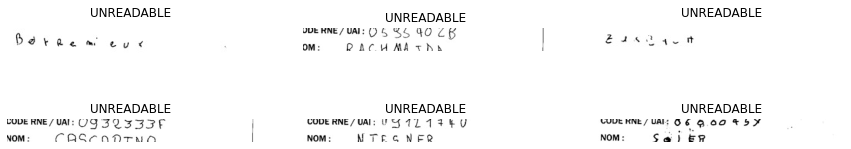

In [12]:
unreadables = train[train['IDENTITY'] == 'UNREADABLE']
unreadables.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadables.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadables.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [13]:
# Drop unreadables 
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [14]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [15]:
# Reset index 
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

Data preprocessin before training

In [16]:
def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255 
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [17]:
# Train model with 20000 images and validate on 2000 images
train_size = 30000
valid_size= 3000

In [19]:
train_x = []
for i in range(train_size):
    img_dir = '../input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)
    
valid_x = []
for i in range(valid_size):
    img_dir = '../input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [20]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

**Labels for CTC loss. Labels are converted into unique numbers representing distinct characters in training dataset**

In [21]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64

In [22]:
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
    return np.array(label_num)

In [23]:
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

**Check a random name label to see if can be converted successfuly**

In [24]:
name = 'SIMON'
print(name, '\n',label_to_num(name))

SIMON 
 [18  8 12 14 13]


**Convert all alphabetic names into numeric values. (Training and validation)**

In [25]:
train_y = np.ones([train_size, max_str_len]) * -1 # True numeric-valued labels, add -1 padding
train_label_len = np.zeros([train_size, 1]) # Length of each true labels without padding
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2) # Length of each predicted label.
train_output = np.zeros([train_size]) # Dummy output for CTC loss

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])  
    
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

Check a random name label for its converted numeric label

In [26]:
print('True label : ',train.loc[305, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], '\ntrain_input_len : ', train_input_len[100])

True label :  ARIANE 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


# Build CNN model

In [27]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

**CTC loss function**

In [28]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [29]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

**Model training**

In [30]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

Epoch 1/60
235/235 [==============================] - 51s 165ms/step - loss: 39.8003 - val_loss: 20.7700
Epoch 2/60
235/235 [==============================] - 36s 153ms/step - loss: 20.2730 - val_loss: 20.0541
Epoch 3/60
235/235 [==============================] - 37s 156ms/step - loss: 19.8952 - val_loss: 19.7657
Epoch 4/60
235/235 [==============================] - 37s 156ms/step - loss: 19.5641 - val_loss: 19.2225
Epoch 5/60
235/235 [==============================] - 36s 155ms/step - loss: 18.9858 - val_loss: 18.3935
Epoch 6/60
235/235 [==============================] - 37s 156ms/step - loss: 18.0564 - val_loss: 17.3983
Epoch 7/60
235/235 [==============================] - 36s 153ms/step - loss: 16.9479 - val_loss: 16.2324
Epoch 8/60
235/235 [==============================] - 37s 156ms/step - loss: 15.4139 - val_loss: 14.3298
Epoch 9/60
235/235 [==============================] - 37s 157ms/step - loss: 13.5684 - val_loss: 12.1631
Epoch 10/60
235/235 [==============================] - 

**Test performance on validation set**

In [31]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [32]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 78.56%
Correct words predicted      : 65.20%


**Test set prediction**

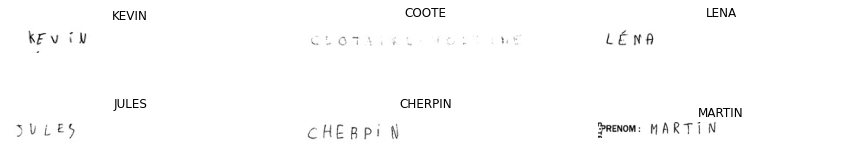

In [35]:
test = pd.read_csv('../input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '../input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)